In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import pandas as pd
import math
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
from matplotlib import rc

def custom_grouping(index):
    return index // 1000

names_bw=['time', 'bw', 'op1', 'size', 'op2' ]
names_latency=['time', 'latency', 'op2', 'write_size', 'op3']

In [39]:
# Define a custom grouping function
  
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/HM-Hybrid/90-10-LBA/90Util/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
#df = pd.read_csv('/home/surbhi/measurements/worst_case/HM-Hybrid/75Util/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
#df = pd.read_csv('/home/surbhi/measurements/worst_case/HM-Hybrid/25Util.147Zones.WakeCount/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = round(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = df['submission_time'] + df['duration']

In [40]:
# Step 3: Determine the start and end time of the entire test
start_time = df['submission_time'].min()
end_time = math.ceil(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = 1048576 #1MB
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)
last_non_zero_index = data_written_ms[data_written_ms.ne(0).any(axis=1)].index[-1]
data_written_ms = data_written_ms.loc[:last_non_zero_index]

/tmp/ipykernel_7434/3920337363.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.90982398
 7491.90982398 7491.90982398 7491.90982398 7491.90982398 7491.9

46079


In [41]:
#assert math.ceil(data_written_ms.data_written_bytes.sum()) == len(df)*1024*1024
print(math.ceil(data_written_ms.data_written_bytes.sum()))
print(len(df) * 1024 * 1024)

48318382081
48318382080


In [42]:
chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
print(df_grouped.describe())
print(df_grouped.info())

             index  data_written_bytes  cumulative_gb
count  6963.000000         6963.000000    6963.000000
mean   3481.000000            6.617837      40.093490
std    2010.189295           28.622938       5.025548
min       0.000000            0.000000       0.071197
25%    1740.500000            0.315068      38.451278
50%    3481.000000            0.371748      40.746892
75%    5221.500000            0.466159      42.969788
max    6962.000000          207.007791      45.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6963 entries, 0 to 6962
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               6963 non-null   int64  
 1   data_written_bytes  6963 non-null   float64
 2   cumulative_gb       6963 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 163.3 KB
None


Average1: 1
Average2: 155


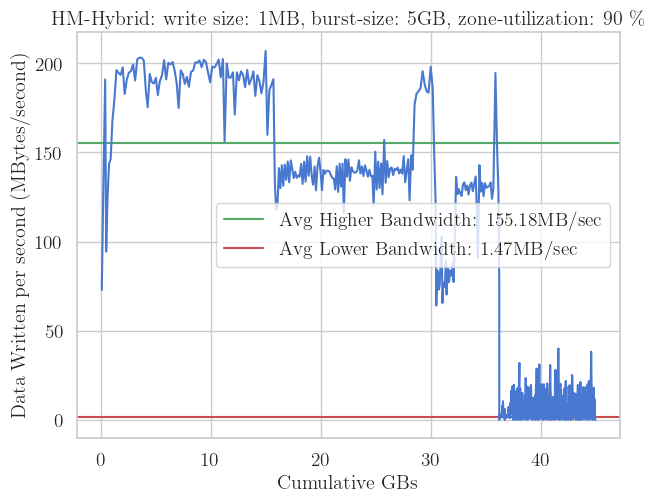

In [43]:
data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'
fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-Hybrid: write size: 1MB, burst-size: 5GB, zone-utilization: 90 \%")
    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/HM-Hybrid/1M_90Util_HMHybrid_CGBW.png', bbox_inches='tight')
plt.show()

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0
The highest duration: 240904.207591


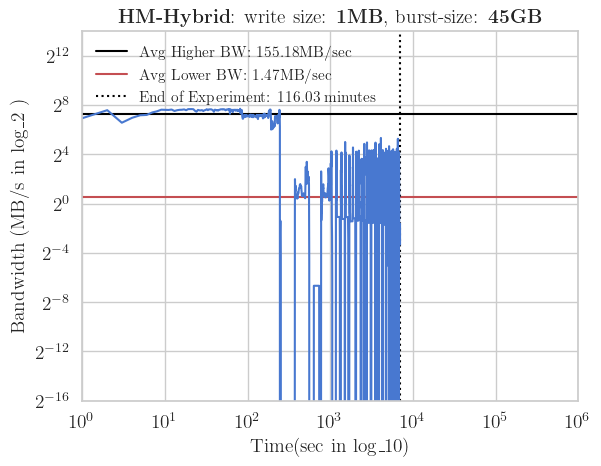

In [44]:
from matplotlib.scale import LogScale

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
#df_grouped['ln'] = np.log2(df_grouped['data_written_bytes'])
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)

#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])

# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")

max_duration = max(df['duration'])
print(f"The highest duration: {max_duration}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)
#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xtime = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xtime) + ' minutes')
plt.legend(loc='upper left', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-Hybrid}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$", fontsize=14)  
plt.savefig('/home/surbhi/github/surbhi-plots/new/HM-Hybrid/1M_90Util_HMHybrid_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_90Util_HMHybrid_BW.pdf', bbox_inches='tight', format="pdf")
plt.savefig('/home/surbhi/Downloads/1M_90Util_HMHybrid_BW.jpeg', bbox_inches='tight')
plt.show()

0.452190423
240.904207591


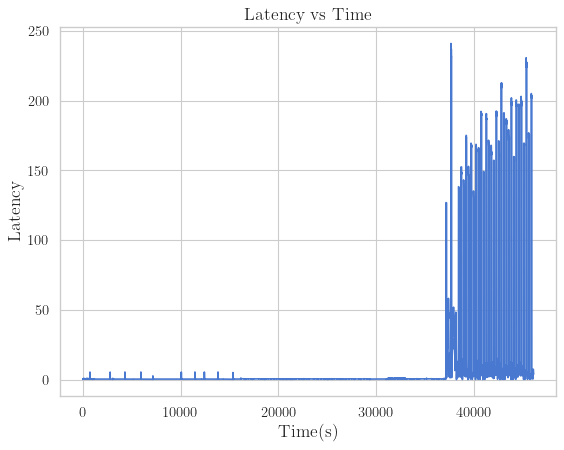

In [45]:
df = pd.read_csv('/home/surbhi/measurements/worst_case/HM-Hybrid/90-10-LBA/90Util/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
#df = pd.read_csv('/home/surbhi/measurements/worst_case/HM-Hybrid/Empty.147Zones.WakeCount/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['duration'] = df['duration']/1e9 #convert ns to seconds

# Plot the data
# Create the line plot
plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.grid(True)  # Optionally, add grid lines
plt.plot(df.index, df['duration'])

# Add labels and title
plt.xlabel('Time(s)', fontsize=16)

plt.ylabel('Latency', fontsize=16)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Latency vs Time', fontsize=16)
#df.describe()
print(str(df['duration'].median()))
print(str(df['duration'].max()))

In [46]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/HM-Hybrid/uniform/1MB/90Util/round2/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)


/tmp/ipykernel_7434/1762662574.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.17744131
 9019.17744131 9019.17744131 9019.17744131 9019.17744131 9019.1

46079
Min Idx: 
261
Average1: 1
Average2: 139


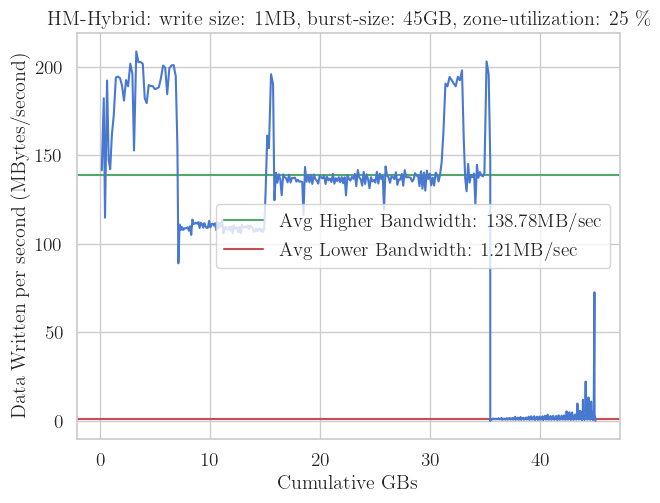

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


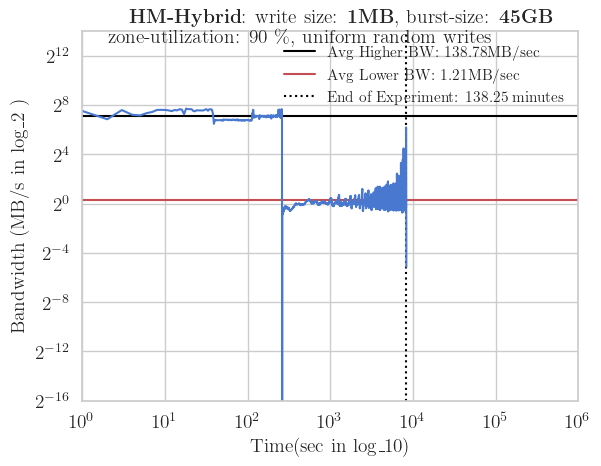

8295
1.209662624002715
138.78462014794727
Time taken: 138.25


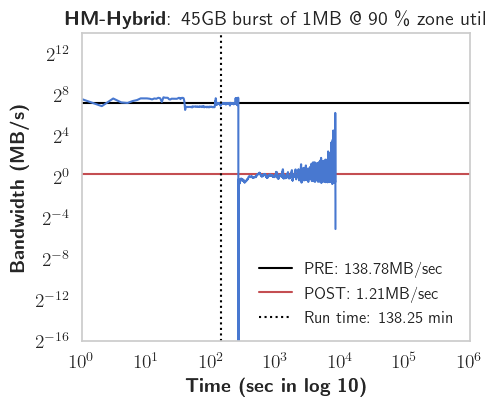

In [47]:

fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-Hybrid: write size: 1MB, burst-size: 45GB, zone-utilization: 25 \%")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/HM-Hybrid/1M_90Util_HMHybrid_uniform_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.title(r"$\textbf{HM-Hybrid}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ \\ zone-utilization: 90 \%, uniform random writes",fontsize=14)    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/HM-Hybrid/1M_90Util_HMHybrid_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90Util_HMHybrid_uniform_BW.pdf', bbox_inches='tight', format="pdf")
plt.show()
print(str(df_grouped.index[-1]))


#now plot the data with seaborn
#remove the grid and use white background
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)
#sns.set_style("ticks") 
sns.set_palette("muted")
#sns.set_context("talk")
plt.figure(figsize=(5, 4))
plt.grid(False)

print(str(average_mode1))
print(str(average_mode2))
plt.axhline(y=average_mode2, color='black', linestyle='-', label='PRE: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='POST: ' + avg_bw_str1)
#plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
#plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)

print("Time taken: " + str(xmin))
plt.title(r"$\textbf{HM-Hybrid}$: 45GB burst of 1MB @ 90 \% zone util")
ax = sns.lineplot(x='index', y='data_written_bytes', data=df_grouped)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks, [str(2**i) for i in range(-16, 14, 2)])
# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

lowest_power_of_2 = 2 ** -16
ax.set_ylim(lowest_power_of_2 , 2**14)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
#set x-axis to log scale
ax.set_xscale('log')
#set y-axis to log base 2 scale
ax.set_yscale('log', base=2)
plt.ylabel(r'$\textbf{Bandwidth (MB/s)}$', fontsize=14)

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks,fontsize=14)

ax.axvline(x=xmin, color='black', linestyle=':', label='Run time: ' + str(xmin) + ' min')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\textbf{Time (sec in log 10)}$', fontsize=14)

plt.legend(loc='lower right', fontsize=12, frameon=False)

plt.savefig('/home/surbhi/Downloads/1M_90Util_HMHybrid_uniform_BW.pdf', bbox_inches='tight', format="pdf")

In [48]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('/home/surbhi/measurements/worst_case/HM-Hybrid/90-10-LBA/25Util/147Zones.WakeOne/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = np.floor(df['submission_time'] - df.iloc[0].submission_time)
df['duration'] = df['duration']/1e6 #convert ns to ms
df['completion_time'] = np.floor(df['submission_time'] + df['duration'])

# Step 3: Determine the start and end time of the entire test
start_time = int(df['submission_time'].min())
end_time = int(df['completion_time'].max())


# Step 4: Create new DataFrames to represent each  millisecond between the start and end time of the entire test
data_written_ms = pd.DataFrame(index=range(start_time, end_time + 1, 1), columns=['data_written_bytes'])
data_written_ms['data_written_bytes'] = 0

# Step 5: Iterate through each write request, calculate the data size for each time interval, and update the corresponding entries in the DataFrames
for index, row in df.iterrows():
    duration = row['duration']
    start = int(row['submission_time'])
    end = start+math.floor(duration)
    
    payload = (1024 * 1024)
    write_rate_per_ms = payload / max(duration, 1.)
    assert(write_rate_per_ms <= payload)
    residue = payload - write_rate_per_ms * math.floor(duration)
    assert (payload >= (write_rate_per_ms * math.floor(duration)))
    data_written_ms.loc[start:end-1] += write_rate_per_ms
    # residue could be zero when last == end
    data_written_ms.loc[end] += residue

print(index)
data_written_ms.reset_index(drop=True, inplace=True)

chunk_size = 10000
results = []
for i in range(0, len(data_written_ms), chunk_size):
    chunk = data_written_ms.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['data_written_bytes'].cumsum() / (1024 ** 3)
df_grouped['data_written_bytes'] = df_grouped['data_written_bytes'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
#print(df_grouped.describe())
#print(df_grouped.info())
print("Min Idx: \n" + str(df_grouped['data_written_bytes'].idxmin()))

data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'

# Plot vertical lines at x where y is higher than the threshold

#cid = plt.figure().canvas.mpl_connect('button_press_event', mouse_event)


/tmp/ipykernel_7434/2022973925.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717.14670019
 11717.14670019 11717.14670019 11717.14670019 11717

46079
Min Idx: 
318
Average1: 1
Average2: 132


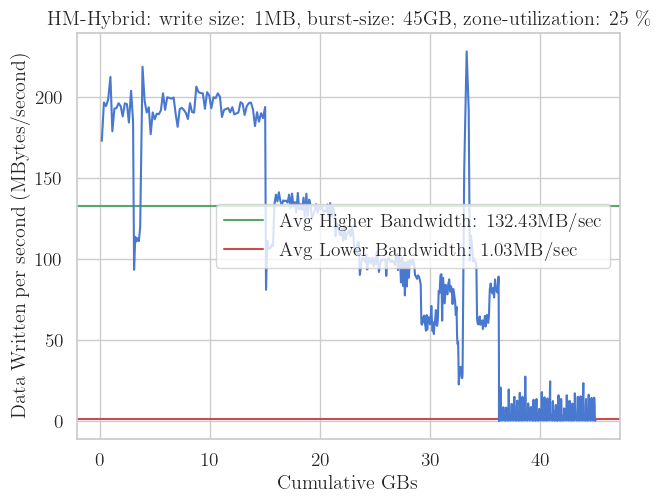

The lowest power of 2 beyond which the plot won't go: 1.52587890625e-05, 0.0


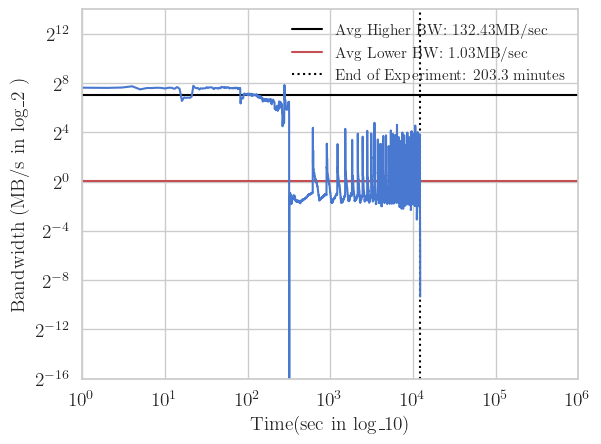

12198


In [49]:

fig, ax = plt.subplots()
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)

plt.legend(loc='center right', fontsize=14)
# Plot the data size over time for each resolution
#plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 8000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
plt.xlabel('Cumulative GBs')
plt.ylabel('Data Written per second (MBytes/second)')
plt.grid(True)  # Optionally, add grid lines
plt.title("HM-Hybrid: write size: 1MB, burst-size: 45GB, zone-utilization: 25 \%")
    
plt.savefig('/home/surbhi/github/surbhi-plots/new/HM-Hybrid/1M_90Util_HMHybrid_uniform_CGBW.png', bbox_inches='tight')
plt.show()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.axhline(y=average_mode2, color='black', linestyle='-', label='Avg Higher BW: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower BW: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
#plt.plot(df_grouped.index, df_grouped['data_written_bytes'])

#plt.xlabel('Logarithmic (base 10) Time in seconds', fontsize=14)
#plt.ylabel('Logarithmic (base 2) Bandwidth (MB/sec)', fontsize=14)

plt.xlabel('Time(sec in log_{10})', fontsize=14)
plt.ylabel('Bandwidth (MB/s in log_2 )', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.yticks(np.arange(0, 80, 10), fontsize=14)
plt.xscale('log', base=10)

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks)
ax = plt.gca()

# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

# Find the minimum Y-value in the dataset
y_min = min(df_grouped['data_written_bytes'])
# Find the closest lower power of 2
#lowest_power_of_2 = 2 ** np.floor(np.log2(y_min))
lowest_power_of_2 = 2 ** -16
print(f"The lowest power of 2 beyond which the plot won't go: {lowest_power_of_2}, {y_min}")
# Set Y-axis limits to include the full range of ticks
# Set Y-axis limits
ax.set_ylim(lowest_power_of_2 , 2**14)
#ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
# Set the same number of ticks for all plots

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks)

#plt.yscale('log', base=10)
#plt.yticks(np.arange(0, 300, 50), fontsize=14)
#plt.xticks(np.arange(0, 8000, 1000), fontsize=14)
#plt.grid(True)  # Optionally, add grid lines

xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='End of Experiment: ' + str(xmin) + ' minutes')
plt.legend(loc='upper right', fontsize=11, frameon=False)

plt.plot(df_grouped.index, df_grouped['data_written_bytes'])
#plt.title(r"$\textbf{HM-Hybrid}$: write size: $\textbf{1MB}$, burst-size: $\textbf{45GB}$ \\ zone-utilization: 75 \%, zipf random writes",fontsize=14)    
#plt.savefig('/home/surbhi/github/surbhi-plots/new/HM-Hybrid/1M_90Util_HMHybrid_BW.pdf', bbox_inches='tight', format="pdf")
#plt.savefig('/home/surbhi/Downloads/1M_90Util_HMHybrid_uniform_BW.pdf', bbox_inches='tight', format="pdf")
plt.show()
print(str(df_grouped.index[-1]))

1.0307321189436194
132.4271983189704


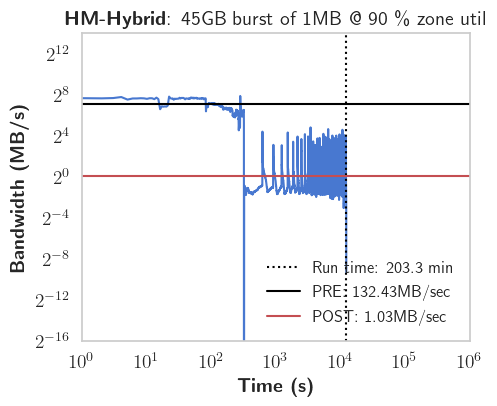

In [50]:
#now plot the data with seaborn
#remove the grid and use white background
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)
#sns.set_style("ticks") 
sns.set_palette("muted")
#sns.set_context("talk")
plt.figure(figsize=(5, 4))
plt.grid(False)
ax = sns.lineplot(x='index', y='data_written_bytes', data=df_grouped)
plt.title(r"$\textbf{HM-Hybrid}$: 45GB burst of 1MB @ 90 \% zone util")

common_yticks = [2**i for i in range(-16, 14, 2)]
plt.yticks(common_yticks, [str(2**i) for i in range(-16, 14, 2)])
# Custom formatter to display ticks as powers of 2
def log2_format(y, pos):
    return f'$2^{{{int(np.log2(y))}}}$' if y > 0 else '0'

lowest_power_of_2 = 2 ** -16
ax.set_ylim(lowest_power_of_2 , 2**14)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(log2_format))
plt.yscale('log', base=2)
#set x-axis to log scale
ax.set_xscale('log')
#set y-axis to log base 2 scale
ax.set_yscale('log', base=2)
plt.ylabel(r'$\textbf{Bandwidth (MB/s)}$', fontsize=14)

# Custom formatter to display ticks as powers of 10
def log10_format(y, pos):
    return f'$10^{{{int(np.log10(y))}}}$' if y > 0 else '0'

common_ticks = [10**0, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(log10_format))
ax.set_xlim(10**0, 10**5)
plt.xticks(common_ticks,fontsize=14)
xmax = df_grouped.index.max()
# Add a vertical line at the end of the experiment
xmin = round(int(xmax)/60, 2)
ax.axvline(x=xmax, color='black', linestyle=':', label='Run time: ' + str(xmin) + ' min')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\textbf{Time (s)}$', fontsize=14)

print(str(average_mode1))
print(str(average_mode2))
plt.axhline(y=average_mode2, color='black', linestyle='-', label='PRE: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='POST: ' + avg_bw_str1)
plt.legend(loc='lower right', fontsize=12, frameon=False)

plt.savefig('/home/surbhi/Downloads/1M_90Util_HMHybrid_uniform_BW.pdf', bbox_inches='tight', format="pdf")
  

